In [41]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# respective classes for a label
classes = {
    0 : "sadness",
    1 : "joy",
    2 : "love",
    3 : "anger",
    4 : "fear",
    5 : "surprise"
}

In [42]:
# Load embeddings and labels
bert_train1 = np.load("bert_train.npy")
bert_val1 = np.load("bert_val.npy")
bert_test1 = np.load("bert_test.npy")

roberta_train1 = np.load("roberta_train.npy")
roberta_val1 = np.load("roberta_val.npy")
roberta_test1 = np.load("roberta_test.npy")

xlnet_train1 = np.load("xlnet_train.npy")
xlnet_val1 = np.load("xlnet_val.npy")
xlnet_test1 = np.load("xlnet_test.npy")

y_train1 = np.load("y_train.npy")
y_val1 = np.load("y_val.npy")
y_test1 = np.load("y_test.npy")

c:\Users\Abhinav Reddy\OneDrive\Desktop\environment\myenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Train Loss: 1.1333, Val Loss: 1.5011
Epoch [2/20], Train Loss: 0.4116, Val Loss: 0.8415
Epoch [3/20], Train Loss: 0.2573, Val Loss: 0.3806
Epoch [4/20], Train Loss: 0.2074, Val Loss: 0.2434
Epoch [5/20], Train Loss: 0.1823, Val Loss: 0.2066
Epoch [6/20], Train Loss: 0.1673, Val Loss: 0.1946
Epoch [7/20], Train Loss: 0.1571, Val Loss: 0.1893
Epoch [8/20], Train Loss: 0.1506, Val Loss: 0.1854
Epoch [9/20], Train Loss: 0.1435, Val Loss: 0.1825
Epoch [10/20], Train Loss: 0.1397, Val Loss: 0.1798
Epoch [11/20], Train Loss: 0.1354, Val Loss: 0.1773
Epoch [12/20], Train Loss: 0.1308, Val Loss: 0.1750
Epoch [13/20], Train Loss: 0.1275, Val Loss: 0.1733
Epoch [14/20], Train Loss: 0.1263, Val Loss: 0.1714
Epoch [15/20], Train Loss: 0.1221, Val Loss: 0.1702
Epoch [16/20], Train Loss: 0.1206, Val Loss: 0.1693
Epoch [17/20], Train Loss: 0.1182, Val Loss: 0.1678
Epoch [18/20], Train Loss: 0.1178, Val Loss: 0.1668
Epoch [19/20], Train Loss: 0.1146, Val Loss: 0.1656
Epoch [20/20], Train 

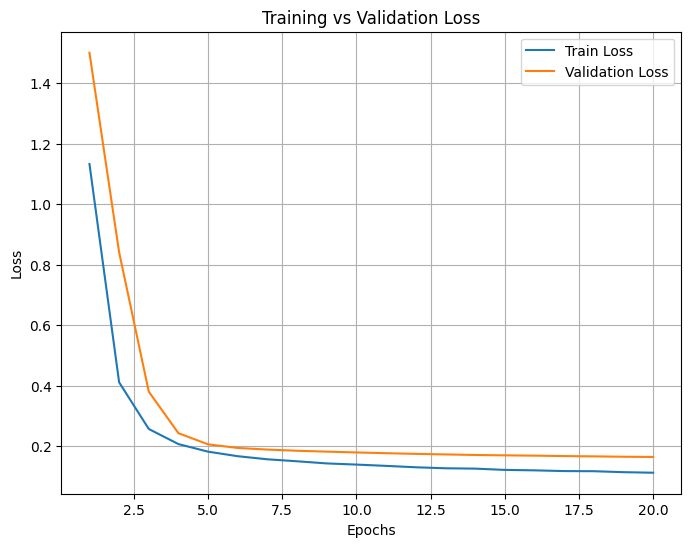

In [ ]:
#                                                                    -----------------------------  MODEL 2  ----------------------------------

# Define Attention Fusion Layer
class AttentionFusion(nn.Module):
    def __init__(self, embedding_dim):
        super(AttentionFusion, self).__init__()
        self.attention_mlp = nn.Sequential(
            nn.Linear(embedding_dim, 128),  
            nn.ReLU(),
            nn.Linear(128, 1),  # Output attention scores for 3 embeddings
        )
        self.softmax = nn.Softmax(dim=1)  

    def forward(self, embeddings):
        """
        embeddings: Shape (batch_size, 3, embedding_dim)
        """
        attention_scores = self.attention_mlp(embeddings)  # Shape: (batch_size, 3, 1)
        attention_weights = self.softmax(attention_scores)  # Shape: (batch_size, 3, 1)
        fused_embedding = torch.sum(attention_weights * embeddings, dim=1) 
        return fused_embedding


# Define AttentionClassifier with Attention
class AttentionClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(AttentionClassifier, self).__init__()
        self.fusion_layer = AttentionFusion(embedding_dim)

        self.fc1 = nn.Linear(embedding_dim, 768)  
        self.bn1 = nn.BatchNorm1d(768)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(768, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)

        self.fc4 = nn.Linear(256, num_classes)  

    def forward(self, embeddings):
        fused_embedding = self.fusion_layer(embeddings)

        x = self.fc1(fused_embedding)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)  
        return x


# Convert Data to Tensor (Use Stacking Instead of Concatenation)
def prepare_data(bert, roberta, xlnet, y):
    embeddings = np.stack([bert, roberta, xlnet], axis=1)  # (batch_size, 3, embedding_dim)
    X_tensor = torch.tensor(embeddings, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return X_tensor, y_tensor

X_train_tensor_2, y_train_tensor_2 = prepare_data(bert_train1, roberta_train1, xlnet_train1, y_train1)
X_val_tensor_2, y_val_tensor_2 = prepare_data(bert_val1, roberta_val1, xlnet_val1, y_val1)
X_test_tensor_2, y_test_tensor_2 = prepare_data(bert_test1, roberta_test1, xlnet_test1, y_test1)

# Model Initialization
embedding_dim = X_train_tensor_2.shape[2]
num_labels = 6
model1 = AttentionClassifier(embedding_dim, num_labels)

# Loss & Optimizer
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.AdamW(model1.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler_2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_2, mode='min', factor=0.5, patience=3, verbose=True)

# Dataloader
batch_size = 2048
train_dataset_2 = data.TensorDataset(X_train_tensor_2, y_train_tensor_2)
val_dataset_2 = data.TensorDataset(X_val_tensor_2, y_val_tensor_2)
train_loader_2 = data.DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True)
val_loader_2 = data.DataLoader(val_dataset_2, batch_size=batch_size, shuffle=False)

# Training Loop
epochs = 20
best_val_loss = float("inf")
patience = 10
counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model1.train()
    train_loss, correct_train, total_train = 0, 0, 0
    for X_batch, y_batch in train_loader_2:
        optimizer_2.zero_grad()
        outputs = model1(X_batch)
        loss = criterion_2(outputs, y_batch)
        loss.backward()
        optimizer_2.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    avg_train_loss = train_loss / len(train_loader_2)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model1.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_2:
            outputs = model1(X_batch)
            loss = criterion_2(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    avg_val_loss = val_loss / len(val_loader_2)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    scheduler_2.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model1, "best_model_attention.pth")  
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

# Testing the Model with test dataset
classifier3 = torch.load("best_model_attention.pth", weights_only=False)
classifier3.eval()

with torch.no_grad():
    outputs = classifier3(X_test_tensor_2)
    _, preds = torch.max(outputs, 1)

y_test_np = y_test_tensor_2.numpy()
preds_np = preds.numpy()

report_model2 = classification_report(y_test_np, preds_np, digits=4,output_dict=True)

# Plot Loss & Accuracy
def plot_metrics(train_vals, val_vals, label, ylabel):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_vals) + 1), train_vals, label=f"Train {label}")
    plt.plot(range(1, len(val_vals) + 1), val_vals, label=f"Validation {label}")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(f"Training vs Validation {label}")
    plt.legend()
    plt.grid()
    plt.show()

plot_metrics(train_losses, val_losses, "Loss", "Loss")

In [44]:
def get_embedding(text, model_name):
    
    tokenizer = AutoTokenizer.from_pretrained(model_name + "_finetuned_emotion")
    model = AutoModelForSequenceClassification.from_pretrained(model_name + "_finetuned_emotion")
    model.eval()

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs,  output_hidden_states=True)

    # Extract hidden states
    hidden_states = outputs.hidden_states

    if model_name in ["bert", "roberta"]:
    # Get CLS token embedding (pooled output)
        cls_embedding = hidden_states[-1][:, 0, :]  # (batch_size, hidden_dim)

    elif model_name == "xlnet":
    # XLNet doesn't have CLS token, so take last token's hidden state
        cls_embedding = hidden_states[-1][:, -1, :] 
    
    logits = outputs.logits  # Raw model outputs before softmax
    predicted_class = torch.argmax(logits, dim=1).item()
    
    return cls_embedding.numpy(), predicted_class


def get_combined_embeddings(text):
    bert_emb, pc1 = get_embedding(text, "bert")
    roberta_emb, pc2 = get_embedding(text, "roberta")
    xlnet_emb, pc3 = get_embedding(text, "xlnet")

    embeddings = np.stack([bert_emb, roberta_emb, xlnet_emb], axis=1)  # (batch_size, 3, embedding_dim)
    X_tensor = torch.tensor(embeddings, dtype=torch.float32) #(1, 3, 768)

    return X_tensor, pc1, pc2, pc3

texts = ["im feeling dazed and alot of things in my mind",
         "i always feel so pressured",
         "i electrocuted my thumb and i cant type too well because i cant really you know feel some of my fingers as an acceptable excuse for a late paper",
         "im making some more mood icons right now to let you see how i feel and think and of course its all charming",
         "Many people eat cereal for breakfast"]

for sample_text in texts:

    S_tensor, pc1, pc2, pc3 = get_combined_embeddings(sample_text)

    with torch.no_grad():
        outputs = classifier3(S_tensor)
        _, preds = torch.max(outputs, 1)

    print(f"Sentence -- {sample_text}")
    print(f" Predicted class by attention model : {classes[preds.item()]}")
    print(f" Predicted class by bert model : {classes[pc1]}")
    print(f" Predicted class by roberta model : {classes[pc2]}")
    print(f" Predicted class by xlnet model : {classes[pc3]}")
    print()


Sentence -- im feeling dazed and alot of things in my mind
 Predicted class by attention model : surprise
 Predicted class by bert model : surprise
 Predicted class by roberta model : surprise
 Predicted class by xlnet model : fear

Sentence -- i always feel so pressured
 Predicted class by attention model : fear
 Predicted class by bert model : fear
 Predicted class by roberta model : fear
 Predicted class by xlnet model : fear

Sentence -- i electrocuted my thumb and i cant type too well because i cant really you know feel some of my fingers as an acceptable excuse for a late paper
 Predicted class by attention model : joy
 Predicted class by bert model : joy
 Predicted class by roberta model : joy
 Predicted class by xlnet model : sadness

Sentence -- im making some more mood icons right now to let you see how i feel and think and of course its all charming
 Predicted class by attention model : joy
 Predicted class by bert model : joy
 Predicted class by roberta model : joy
 Predict

In [45]:
with open("classification_report_model_2.txt", "r") as f:
    report_content = f.read()
    print(report_content)

              precision    recall  f1-score   support

           0     0.9641    0.9640    0.9640       581
           1     0.9684    0.9581    0.9632       695
           2     0.9255    0.9102    0.9178       159
           3     0.9461    0.9424    0.9442       275
           4     0.9319    0.9351    0.9335       224
           5     0.8825    0.9021    0.8922        66

    accuracy                         0.9567      2000
   macro avg     0.9364    0.9353    0.9358      2000
weighted avg     0.9538    0.9494    0.9516      2000

